<h1>Levenberg-Marquardt Algorithm Tensorflow Based Implementation</h1>
The Levenberg-Marquardt (LM) algorithm is the most widely used optimization algorithm. It outperforms simple gradient descent and other conjugate gradient methods in a wide variety of problems. This document aims to show how this algorithm could be implemented using Tensorflow to optimize multi-layer perceptron neural networks.
<h2>Rosenbrock function</h2>
We will use Rosenbrock function as performance test problem. Let's start with its two variables form:<br>
<i>f(x, y) = (a - x)^2 + b(y - x^2)^2</i> and take a = 0.5 and b = 0.5.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def rosenbrock(x, y, a, b):
    return (a - x)**2 + b*(y - x**2)**2

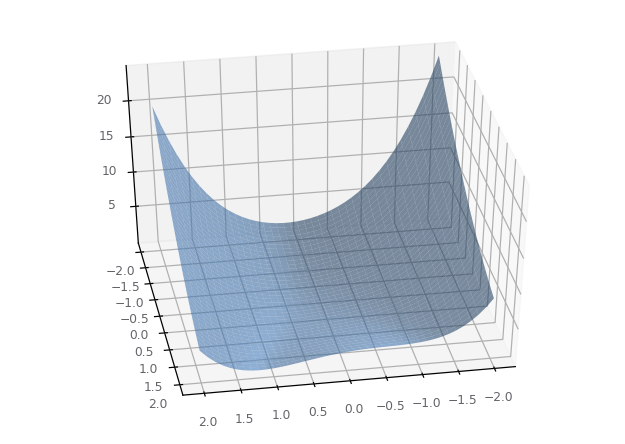

In [3]:
# let's plot it on [(-2,-2), (2, 2)] square
x_grid, y_grid = np.meshgrid(np.arange(-2, 2.1, 0.1), 
                             np.arange(-2, 2.1, 0.1))
z_grid = rosenbrock(x_grid, y_grid, 0.5, 0.5)

fig = plt.figure(figsize=(7, 5), dpi=110)
ax = fig.add_subplot(111, projection='3d')
# configure tick labels appearance
for i in ax.get_yticklabels() + ax.get_xticklabels() + ax.get_zticklabels():
    i.set_fontsize(8)
    i.set_color('#646369')
ax.view_init(40, 80)
ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.6, color='#4A81BF')

<h2>The Problem</h2>
The problem for which the LM algorithm provides a solution is called <i>Nonlinear Least Squares Minimization</i>.<br>
Suppose we performed an experiment and have as set of <i>m</i> data points, <i>(x1, y1, z1), (x2, y2, z2),..., (xm, ym, zm)</i>. We have a model function <i>y = rosenbrock(x, y, a, b)</i>, that in addition to the variables <i>(x, y)</i> also depends on parameters <i>a, b</i>. It is desired to find these parameters such that the surface fits best the given data in the least squares sense.

In [4]:
# let's generate some data points 
data_points = np.array([[x, y, rosenbrock(x, y, 0.5, 0.5)]
                       for x in np.arange(-2, 2.1, 2) 
                       for y in np.arange(-2, 2.1, 2)])
m = data_points.shape[0]
# now, please, forget about values (0.5, 0.5) for a and b
# let's suppose that they are unknown for us and our goal is to find them

# we make initial guess and calculate prediction and residuals
a, b = 5, 5
z_hat = rosenbrock(data_points[:,0], data_points[:,1], a, b)
r = data_points[:,2] - z_hat
# calculate the sum of squares 
loss = r.dot(r.T)
# our goal is to minimize it
print(loss)

98339.0625


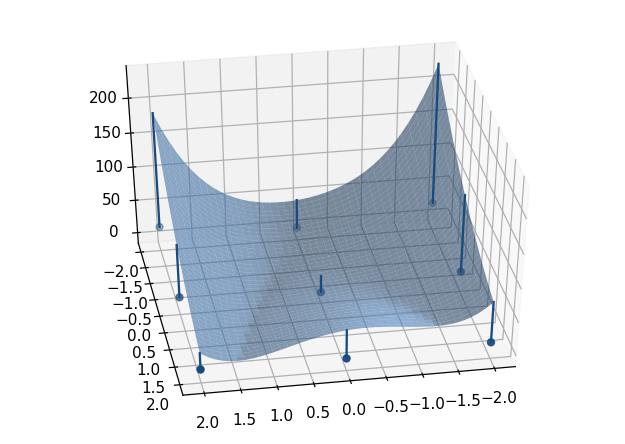

In [5]:
# the situation could be depicted following way:
# the surface is our model based on initial guess a = 5, b = 5
# the dots are our data
# the lines are residuals
# as you can see, our initial guess is very bad
fig = plt.figure(figsize=(7, 5), dpi=110)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40, 80)
ax.scatter(data_points[:,0], data_points[:,1], data_points[:,2], 
           color='#174A7E')
z_hat_grid = rosenbrock(x_grid, y_grid, a, b)
ax.plot_surface(x_grid, y_grid, z_hat_grid, alpha=0.6, color='#4A81BF')
for i in range(m):
    ax.plot([data_points[i, 0], data_points[i, 0]], 
            [data_points[i, 1], data_points[i, 1]], 
            [data_points[i, 2], z_hat[i]], c='#174A7E')